In [13]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import loader_utils
import nuplan_loader
import pickle
import os
import lzma
import numpy as np
import random
import gymnasium as gym
import typing
from metadrive import MetaDriveEnv
from torch.utils.data import TensorDataset, DataLoader
import itertools


from env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from metadrive_model import MetadriveModel
from model_utils import set_lr, deviceof

# CHANGE ME: Set this to the path to the NuPlan data directory
NUPLAN_DATA_PATH = "~/nuplan-v1.1/splits/mini/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
file_iter = iter(loader_utils.getFiles(NUPLAN_DATA_PATH))
trajectories: list[list[State]] = []

In [3]:
for file_path in file_iter:
    trajectories_in_file = nuplan_loader.parse_file(file_path)
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}.")

Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.22.00.38_veh-35_01008_01518.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.22.28.35_veh-35_00620_01164.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.23.36.44_veh-35_00152_00504.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.23.36.44_veh-35_01133_01535.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.23.36.44_veh-35_02035_02387.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.25.14.16.10_veh-35_01690_02183.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.03.12.02.06_veh-35_00233_00609.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.03.13.55.17_veh-35_00073_00426.db.
Loaded 1 trajectories from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.07.12.54.00_veh-35

In [4]:
# pickle the trajectories
if not os.path.exists('./data/nuplan/trajectories.pkl.xz'):
    with lzma.open('./data/nuplan/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [3]:
# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('./data/nuplan/trajectories.pkl.xz', 'rb') as f:
        trajectories: list[list[State]] = pickle.load(f)

In [5]:
import random

idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
n_train = int(len(idm_data)*0.9)
idm_train_data = idm_data[:n_train]
idm_validation_data = idm_data[n_train:]

In [6]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 234603
validation data: 26067


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
mm = MetadriveModel().to(device)
mm.load_state_dict(torch.load('./data/mm.pth'))
mm_optimizer = torch.optim.AdamW(mm.parameters())

In [14]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 768, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc3 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx4x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = F.relu(self.fc2(x)) # Bx768 -> Bx768
        x = self.fc3(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_tensor: torch.Tensor,
        s0_tensor: torch.Tensor,
        s1_tensor: torch.Tensor,
) -> float:
    device = deviceof(mm)
    assert deviceof(idm) == device

    obs_tensor = obs_tensor.to(device)
    s0_tensor = s0_tensor.to(device)
    s1_tensor = s1_tensor.to(device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [15]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor(idm_train_data, torch.device("cpu")),
    state_batch_to_tensor([s0 for s0, _ in idm_train_data], torch.device("cpu")),
    state_batch_to_tensor([s1 for _, s1 in idm_train_data], torch.device("cpu"))
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [16]:
set_lr(idm_optimizer, 1e-4)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 10_000

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_tensor, s0_tensor, s1_tensor = next(idm_train_iter)
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_tensor,
        s0_tensor,
        s1_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 500 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-500:])
        print(f"Step: {idm_step}, Loss: {loss:.5f}")

Step: 500, Loss: 0.00150
Step: 1000, Loss: 0.00049
Step: 1500, Loss: 0.00037
Step: 2000, Loss: 0.00030
Step: 2500, Loss: 0.00024
Step: 3000, Loss: 0.00018
Step: 3500, Loss: 0.00016
Step: 4000, Loss: 0.00015
Step: 4500, Loss: 0.00014
Step: 5000, Loss: 0.00013
Step: 5500, Loss: 0.00012
Step: 6000, Loss: 0.00011
Step: 6500, Loss: 0.00012
Step: 7000, Loss: 0.00011


KeyboardInterrupt: 

In [32]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('nuplan_data/idm.pth'))    

In [37]:
# save idm
if not os.path.exists('nuplan_data/idm.pth'):
    torch.save(idm.state_dict(), 'nuplan_data/idm.pth')

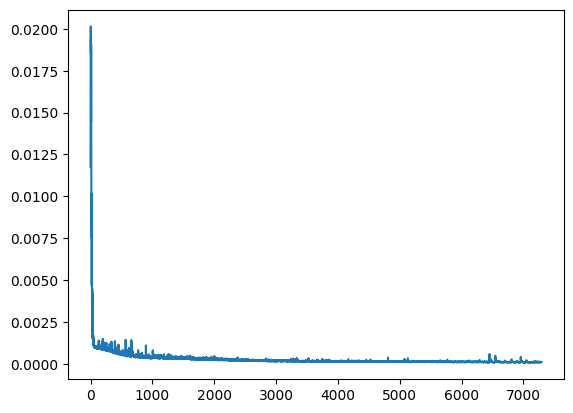

In [17]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

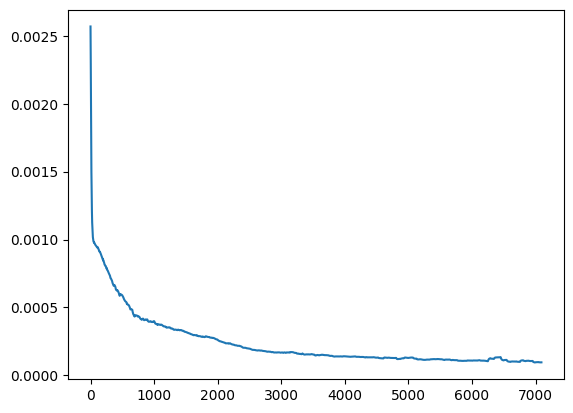

In [18]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((200,))/200, mode='valid')
plt.plot(idm_losses_averaged)

In [19]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 9.388741455040872e-05


In [20]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 9.576259617460892e-05


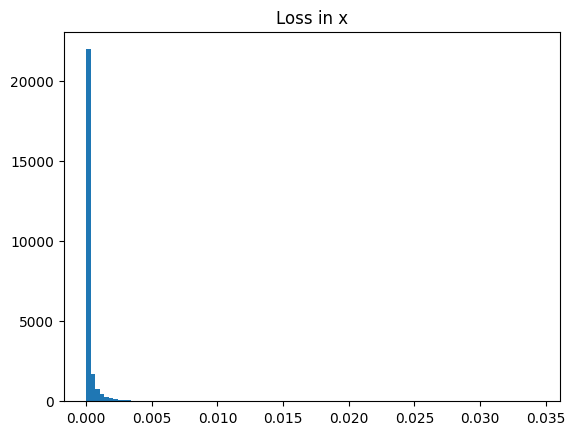

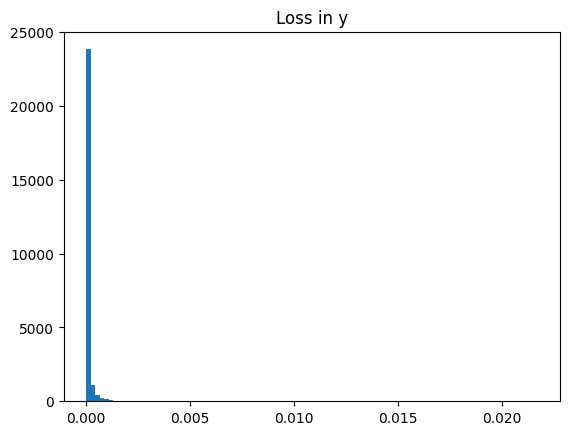

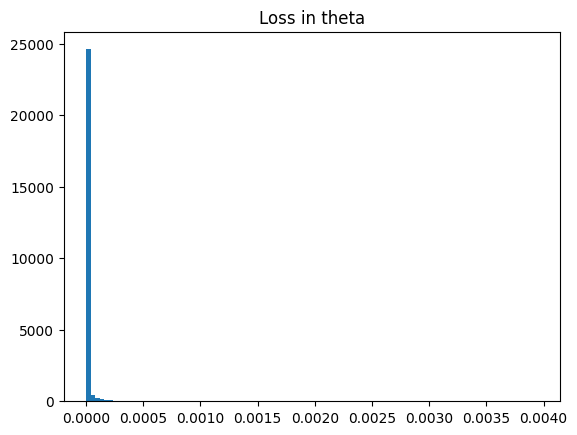

In [21]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


### Enumerate outliers

In [22]:
for i, t in enumerate(trajectories):
    obs_batch = []
    for j in range(len(t)-1):
        obs_batch.append((t[j], t[j+1]))
    
    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
    with torch.no_grad():
        action_pred = idm(obs_tensor)
        s1_pred = mm(s0_tensor, action_pred)

    loss = (s1_pred - s1_tensor)**2

    for j, (lx, ly, lthetax, lthetay) in enumerate(loss):
        if lx > 1 or ly > 1 or lthetax > 1 or lthetay > 1:
            print(f"Trajectory {i}, step {j}")
            print(f"lx: {lx}, ly: {ly}, ltheta: {lthetax + lthetay}")

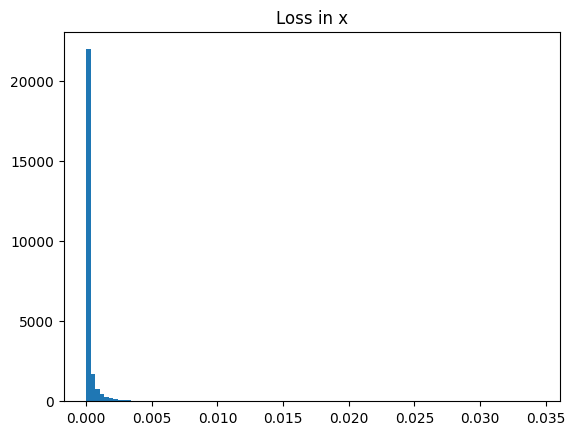

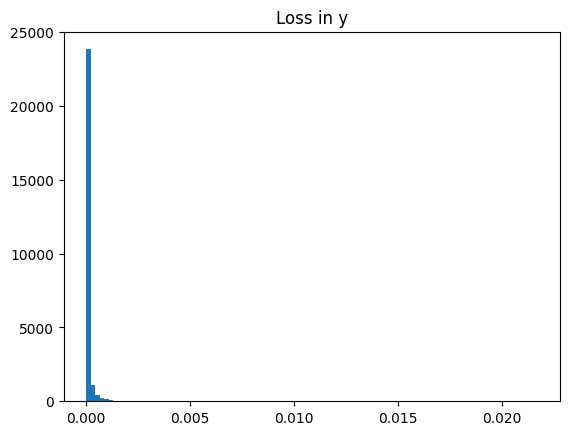

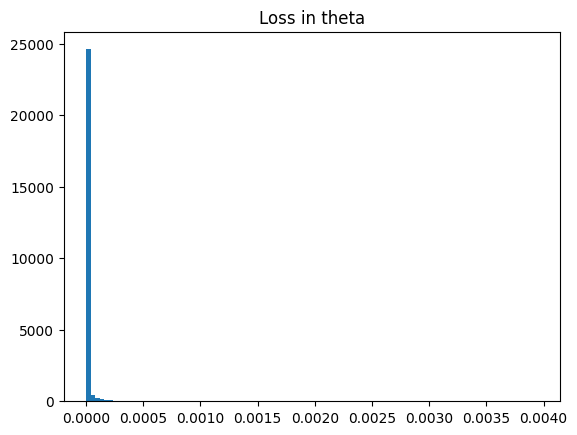

In [23]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()

In [24]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [38]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

### Trajectory Replay

In [44]:
scenario = trajectories[7]

# reset
env.reset()

# allow car to settle
for _ in range(10):
    env.step([0,0])

# set the initial state
for i in range(len(scenario)):
    st = scenario[i]
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])        

### Closed Loop IDM

In [43]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)

(-0.0015387949533760548, 0.01290886290371418)
[-4.22174454 -8.12321091] -2.0494132463173216 [-4.22035707 -8.10973151] -2.049530936477131
(-0.0037843007594347, -0.013508740812540054)
[-4.21997166 -8.09934616] -2.049875571082559 [-4.20932972 -8.0877195 ] -2.049780142777987
(-0.004604003857821226, -0.024038299918174744)
[-4.21173096 -8.05952644] -2.050752017397304 [-4.19201309 -8.05338777] -2.050004759660499
(-0.00486474996432662, -0.029398974031209946)
[-4.19967794 -8.01185226] -2.051852701875834 [-4.16999068 -8.01006014] -2.0500613287807274
(-0.004788524005562067, -0.033794745802879333)
[-4.18358469 -7.95820999] -2.0530335475031745 [-4.14451124 -7.96021973] -2.0498260910798933
(-0.0044049364514648914, -0.03641222417354584)
[-4.16419363 -7.90148306] -2.0541976152156485 [-4.11689972 -7.90626764] -2.0494412746829678
(-0.0036364528350532055, -0.038863830268383026)
[-4.14094019 -7.842278  ] -2.055258884910045 [-4.08795302 -7.84935887] -2.0493529602563156
(-0.0022262674756348133, -0.039482023

### Open Loop IDM

In [42]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(-0.0015387809835374355, 0.012908820062875748)
[-4.22174406 -8.12321091] -2.0494132463173216 [-4.22035707 -8.10973151] -2.049530936477131
(-0.0026797475293278694, -0.0036007422022521496)
[-4.22392464 -8.11546993] -2.0498073941586528 [-4.20932972 -8.0877195 ] -2.049780142777987
(-0.003776834812015295, -0.014009349048137665)
[-4.22208166 -8.09072018] -2.0504809075983346 [-4.19201309 -8.05338777] -2.050004759660499
(-0.004659087862819433, -0.021577320992946625)
[-4.21624708 -8.05415344] -2.0514140792442976 [-4.16999068 -8.01006014] -2.0500613287807274
(-0.005406349431723356, -0.02717965841293335)
[-4.20734882 -8.00888252] -2.052566961680193 [-4.14451124 -7.96021973] -2.0498260910798933
(-0.005956097040325403, -0.0310169979929924)
[-4.19617414 -7.95773363] -2.0538996074896687 [-4.11689972 -7.90626764] -2.0494412746829678
(-0.006333223078399897, -0.033797744661569595)
[-4.18325424 -7.90236712] -2.0553635471408853 [-4.08795302 -7.84935887] -2.0493529602563156
(-0.006479266565293074, -0.03446

In [45]:
env.close()

In [25]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none


In [27]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [28]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

[INFO] Assets version: 0.4.1.2
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event22 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


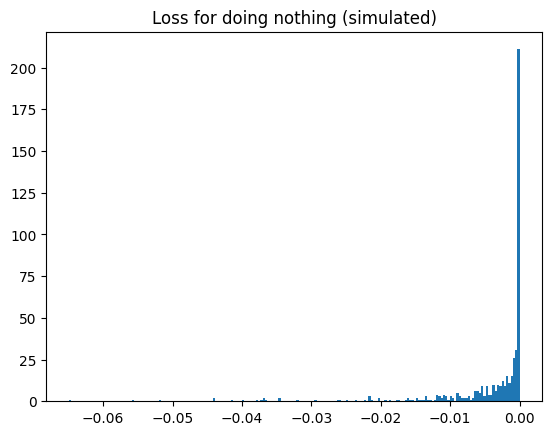

mean -0.004244251589319531
median -0.0007868375827182795


In [29]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

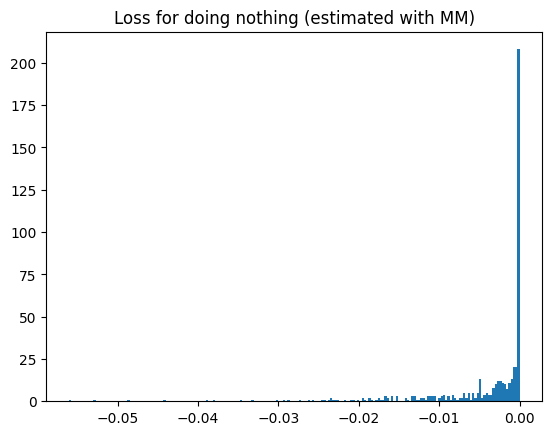

mean -0.004486651801385987
median -0.0008727393351039957


In [30]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

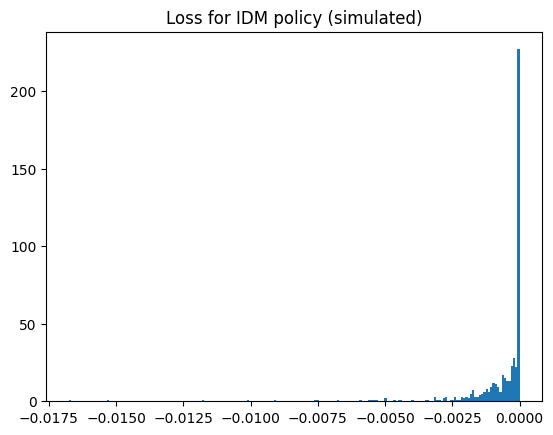

mean -0.0007428921787812756
median -0.0001692305078225131


In [31]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

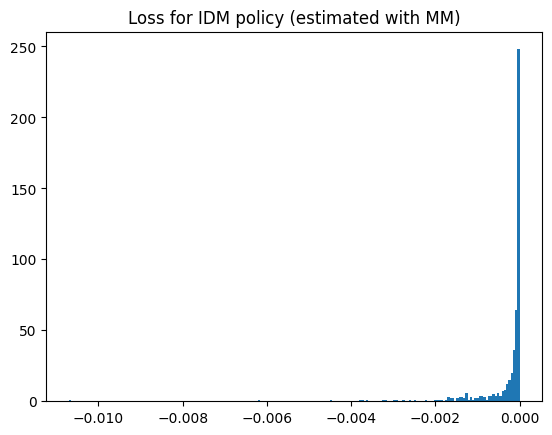

mean -0.00032463126430655367
median -5.429691961281706e-05


In [32]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

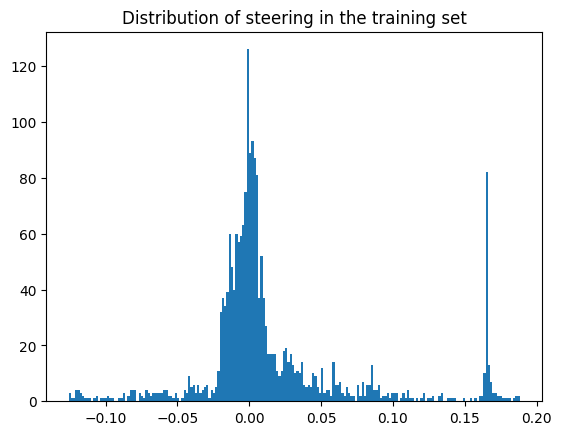

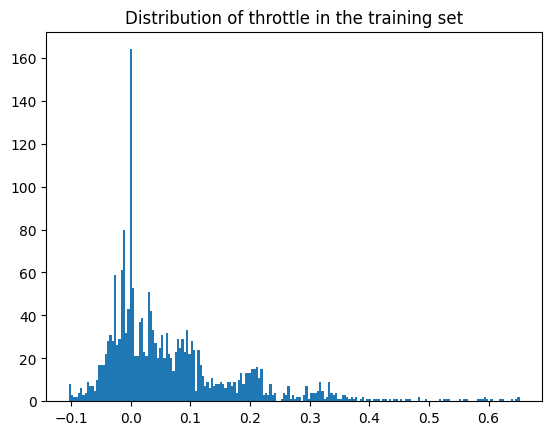

In [33]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()